In [ ]:
# Notebook 3 — 7-Class CNN (train from scratch)
# Colab-ready. Run top-to-bottom.

# 0) Imports & environment checks
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix

print("TensorFlow:", tf.__version__)
print("GPU devices:", tf.config.list_physical_devices('GPU'))



TensorFlow: 2.19.0
GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# 1) GPU safety
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Enabled memory growth on GPU(s).")
    except Exception as e:
        print("Could not set memory growth:", e)



Enabled memory growth on GPU(s).


In [ ]:
# 2) Config — update paths if needed
IMAGE_FOLDER = "/content/drive/MyDrive/HAM10000_images"   # where images live (Notebook1 should have created/cleaned this)
SPLITS_DIR = "/content/drive/MyDrive/splits"              # output from Notebook 1: df_train.csv, df_val.csv, df_test.csv
OUTPUT_DIR = "/content/drive/MyDrive/models"
os.makedirs(OUTPUT_DIR, exist_ok=True)

IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 30
RANDOM_STATE = 42
NUM_CLASSES = 7



In [ ]:
# 3) Load CSV splits
df_train = pd.read_csv(os.path.join(SPLITS_DIR, "df_train.csv"))
df_val   = pd.read_csv(os.path.join(SPLITS_DIR, "df_val.csv"))
df_test  = pd.read_csv(os.path.join(SPLITS_DIR, "df_test.csv"))

print("Train rows:", len(df_train), "Val rows:", len(df_val), "Test rows:", len(df_test))



Train rows: 29491 Val rows: 861 Test rows: 1780


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 4) Ensure filepath column exists (create if missing)
for d in [df_train, df_val, df_test]:
    if 'filepath' not in d.columns:
        d['filename'] = d['image_id'].astype(str) + '.jpg'
        d['filepath'] = d['filename'].apply(lambda x: os.path.join(IMAGE_FOLDER, x))



In [ ]:
# 5) Check labels
if 'dx' not in df_train.columns:
    raise ValueError("Expected column 'dx' in CSVs with class labels (7 classes).")

print("Train label counts:\n", df_train['dx'].value_counts())



Train label counts:
 dx
bcc      4213
bkl      4213
df       4213
vasc     4213
nv       4213
mel      4213
akiec    4213
Name: count, dtype: int64


In [ ]:
# 6) Generators (rescale for from-scratch CNN)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.10,
    height_shift_range=0.10,
    zoom_range=0.10,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_flow = train_datagen.flow_from_dataframe(
    df_train, x_col='filepath', y_col='dx',
    target_size=(IMG_SIZE,IMG_SIZE), color_mode='rgb',
    class_mode='categorical', batch_size=BATCH_SIZE, shuffle=True
)

val_flow = val_datagen.flow_from_dataframe(
    df_val, x_col='filepath', y_col='dx',
    target_size=(IMG_SIZE,IMG_SIZE), color_mode='rgb',
    class_mode='categorical', batch_size=BATCH_SIZE, shuffle=False
)

test_flow = test_datagen.flow_from_dataframe(
    df_test, x_col='filepath', y_col='dx',
    target_size=(IMG_SIZE,IMG_SIZE), color_mode='rgb',
    class_mode='categorical', batch_size=BATCH_SIZE, shuffle=False
)

print("Class indices:", train_flow.class_indices)



Found 29491 validated image filenames belonging to 7 classes.
Found 861 validated image filenames belonging to 7 classes.
Found 1780 validated image filenames belonging to 7 classes.
Class indices: {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [ ]:
# 7) Build 7-class CNN model (based on your code)
def build_7class_cnn(input_shape=(IMG_SIZE,IMG_SIZE,3), num_classes=NUM_CLASSES):
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(32, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        BatchNormalization(),

        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        BatchNormalization(),

        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        BatchNormalization(),

        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

cnn7_model = build_7class_cnn()
cnn7_model.summary()



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 111, 111, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 54, 54, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 26, 26, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,247,367 (84.87 MB)

 Trainable params: 22,246,919 (84.87 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
# 8) Callbacks & checkpoint
checkpoint_path = os.path.join(OUTPUT_DIR, "cnn7_best.h5")
callbacks = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1),
    ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
]



In [ ]:
# 9) Train
history = cnn7_model.fit(
    train_flow,
    validation_data=val_flow,
    epochs=EPOCHS,
    callbacks=callbacks
)




/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
922/922 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4487 - loss: 2.7339
Epoch 1: val_loss improved from inf to 1.32703, saving model to /content/drive/MyDrive/models/cnn7_best.h5


922/922 ━━━━━━━━━━━━━━━━━━━━ 2215s 2s/step - accuracy: 0.4488 - loss: 2.7330 - val_accuracy: 0.5854 - val_loss: 1.3270 - learning_rate: 1.0000e-04
Epoch 2/30
922/922 ━━━━━━━━━━━━━━━━━━━━ 0s 645ms/step - accuracy: 0.5924 - loss: 1.3138
Epoch 2: val_loss did not improve from 1.32703
922/922 ━━━━━━━━━━━━━━━━━━━━ 602s 653ms/step - accuracy: 0.5924 - loss: 1.3137 - val_accuracy: 0.6341 - val_loss: 1.3324 - learning_rate: 1.0000e-04
Epoch 3/30
922/922 ━━━━━━━━━━━━━━━━━━━━ 0s 638ms/step - accuracy: 0.6328 - loss: 1.1022
Epoch 3: val_loss did not improve from 1.32703
922/922 ━━━━━━━━━━━━━━━━━━━━ 597s 647ms/step - accuracy: 0.6328 - loss: 1.1022 - val_accuracy: 0.5238 - val_loss: 1.6147 - learning_rate: 1.0000e-04
Epoch 4/30
922/922 ━━━━━━━━━━━━━━━━━━━━ 0s 642ms/step - accuracy: 0.6618 - loss: 0.9810
Epoch 4: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.

Epoch 4: val_loss did not improve from 1.32703
922/922 ━━━━━━━━━━━━━━━━━━━━ 601s 651ms/step - accuracy: 0.6619 - loss: 

922/922 ━━━━━━━━━━━━━━━━━━━━ 603s 654ms/step - accuracy: 0.7108 - loss: 0.8039 - val_accuracy: 0.6713 - val_loss: 0.9643 - learning_rate: 3.0000e-05
Epoch 6/30
922/922 ━━━━━━━━━━━━━━━━━━━━ 0s 649ms/step - accuracy: 0.7501 - loss: 0.6828
Epoch 6: val_loss did not improve from 0.96432
922/922 ━━━━━━━━━━━━━━━━━━━━ 607s 658ms/step - accuracy: 0.7501 - loss: 0.6828 - val_accuracy: 0.6562 - val_loss: 0.9903 - learning_rate: 3.0000e-05
Epoch 7/30
922/922 ━━━━━━━━━━━━━━━━━━━━ 0s 640ms/step - accuracy: 0.7636 - loss: 0.6336
Epoch 7: val_loss did not improve from 0.96432
922/922 ━━━━━━━━━━━━━━━━━━━━ 598s 649ms/step - accuracy: 0.7636 - loss: 0.6336 - val_accuracy: 0.6771 - val_loss: 1.0201 - learning_rate: 3.0000e-05
Epoch 8/30
922/922 ━━━━━━━━━━━━━━━━━━━━ 0s 640ms/step - accuracy: 0.7754 - loss: 0.6112
Epoch 8: ReduceLROnPlateau reducing learning rate to 8.999999772640877e-06.

Epoch 8: val_loss did not improve from 0.96432
922/922 ━━━━━━━━━━━━━━━━━━━━ 599s 649ms/step - accuracy: 0.7754 - loss:

In [ ]:
# 10) Save last model
cnn7_model.save(os.path.join(OUTPUT_DIR, "cnn7_last.h5"))
print("Saved models to", OUTPUT_DIR)



Saved models to /content/drive/MyDrive/models


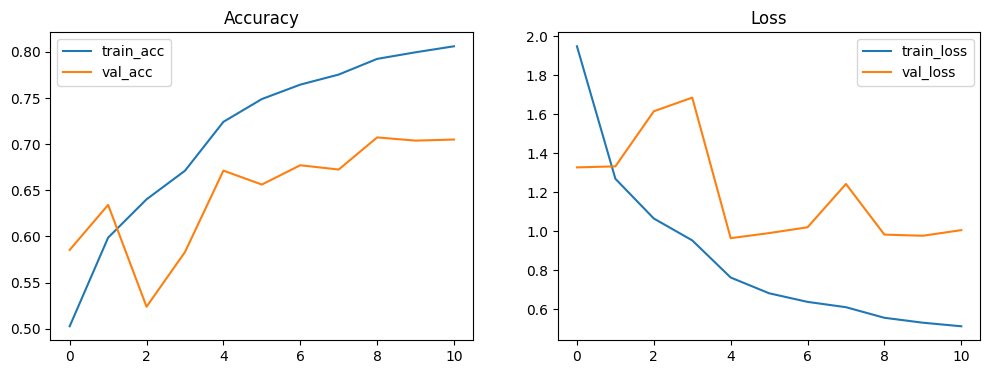

In [ ]:
# 11) Plot training curves
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend(); plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.title('Loss')
plt.show()



In [ ]:
# 12) Evaluate best model on test set
best = load_model(checkpoint_path)
test_steps = int(np.ceil(test_flow.n / test_flow.batch_size))
loss, acc = best.evaluate(test_flow, steps=test_steps, verbose=1)
print(f"Test accuracy: {acc*100:.2f}%, test loss: {loss:.4f}")

# 13) Predictions -> confusion matrix and classification report
test_flow.reset()
y_prob = best.predict(test_flow, steps=test_steps, verbose=1)
y_pred = np.argmax(y_prob, axis=1)
y_true = test_flow.classes  # integer indices



56/56 ━━━━━━━━━━━━━━━━━━━━ 398s 7s/step - accuracy: 0.6686 - loss: 1.1614
Test accuracy: 64.55%, test loss: 1.0353
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 313ms/step



Classification Report (7-class CNN):
              precision    recall  f1-score   support

       akiec     0.3235    0.2037    0.2500        54
         bcc     0.4592    0.5056    0.4813        89
         bkl     0.3724    0.6049    0.4610       205
          df     0.1505    0.6667    0.2456        21
         mel     0.3733    0.5091    0.4308       220
          nv     0.9229    0.7054    0.7996      1171
        vasc     0.6296    0.8500    0.7234        20

    accuracy                         0.6455      1780
   macro avg     0.4616    0.5779    0.4845      1780
weighted avg     0.7378    0.6455    0.6750      1780



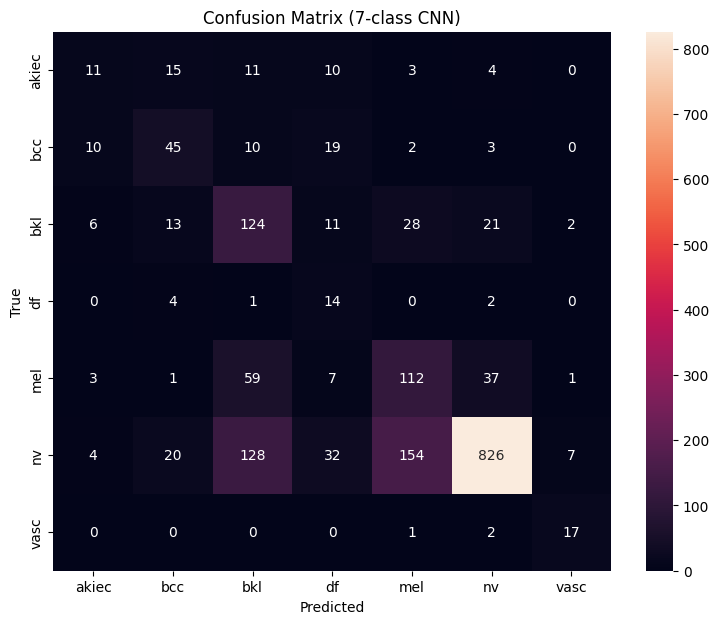

In [ ]:
# Recover class names
inv_class_map = {v:k for k,v in train_flow.class_indices.items()}
y_pred_labels = [inv_class_map[int(i)] for i in y_pred]
y_true_labels = [inv_class_map[int(i)] for i in y_true]

print("\nClassification Report (7-class CNN):")
print(classification_report(y_true_labels, y_pred_labels, digits=4))

cm = confusion_matrix(y_true_labels, y_pred_labels, labels=list(inv_class_map.values()))
plt.figure(figsize=(9,7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=list(inv_class_map.values()), yticklabels=list(inv_class_map.values()))
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix (7-class CNN)')
plt.show()



In [ ]:
# 14) Inference: upload image(s) interactively in Colab and predict
from google.colab import files
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def predict_single_image_7(model, img_path, target_size=(IMG_SIZE,IMG_SIZE)):
    img = load_img(img_path, target_size=target_size)
    arr = img_to_array(img) / 255.0
    arr = np.expand_dims(arr, axis=0)
    prob = model.predict(arr)[0]
    idx = np.argmax(prob)
    label = inv_class_map[idx]
    return label, prob[idx], prob

print("To run inference: upload a file using files.upload()")
uploaded = files.upload()
for fn in uploaded.keys():
    label, conf, allprob = predict_single_image_7(best, fn)
    print(f"File: {fn}  -> Predicted: {label} ({conf*100:.2f}%)")
    # also print probs for all classes optionally
    print("All class probs:", {inv_class_map[i]: float(allprob[i]) for i in range(len(allprob))})


To run inference: upload a file using files.upload()


Saving melanoma.png to melanoma.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 965ms/step
File: melanoma.png  -> Predicted: nv (51.60%)
All class probs: {'akiec': 0.1349075883626938, 'bcc': 0.07983794808387756, 'bkl': 0.002261752961203456, 'df': 0.009773536585271358, 'mel': 0.2560998201370239, 'nv': 0.516023576259613, 'vasc': 0.0010958218481391668}
